# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [275]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [282]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create training set and define training dataloader
## YOUR CODE HERE ##
train_data = torchvision.datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
trainloader=torch.utils.data.DataLoader(train_data,batch_size=5,shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)
testloader=torch.utils.data.DataLoader(test_data,batch_size=5,shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [283]:
"""
I changed the Function according to following link 
https://knowledge.udacity.com/questions/614698
"""

def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        std = (.5, .5, .5)
        mean = (.5, .5, .5)
        for i in range(3):
            image[i] = std[i] * image[i] + mean[i]
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

car


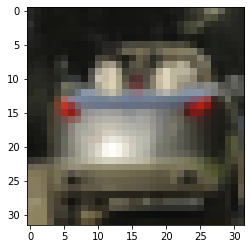

cat


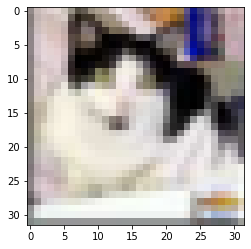

cat


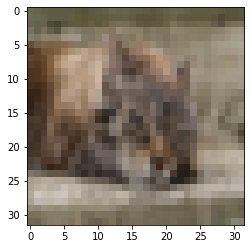

truck


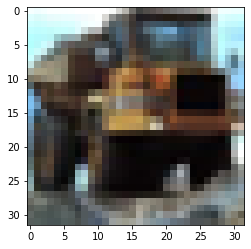

frog


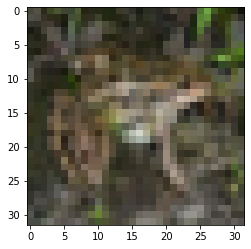

In [284]:
# Explore data
## YOUR CODE HERE ##
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [285]:
## YOUR CODE HERE ##
"""
Build a feed-forward network with dingle hiddden layer
I choose single hidden according the next formula:
Nh = Ns/(α∗ (Ni + No))
     Ni = number of input neurons.
     No = number of output neurons.
     Ns = number of samples in training data set.
     α = an arbitrary scaling factor usually 2-10
"""
model = nn.Sequential(nn.Linear(3072, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [286]:
## YOUR CODE HERE ##
# Define the loss
criterion = nn.NLLLoss()

# Define the optimize
optimizer = optim.SGD(model.parameters(), lr=0.003)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [287]:
## YOUR CODE HERE ##
epochs = 15
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    loss_values = []

    for images, labels in trainloader:
        # Flatten  images into a 1D long vector
        images = images.view(images.shape[0], -1)

        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                output = model.forward(images)
                test_loss += criterion(output, labels)
                
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()       
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/15..  Training Loss: 1.803..  Test Loss: 1.621..  Test Accuracy: 0.420
Epoch: 2/15..  Training Loss: 1.557..  Test Loss: 1.507..  Test Accuracy: 0.469
Epoch: 3/15..  Training Loss: 1.464..  Test Loss: 1.433..  Test Accuracy: 0.494
Epoch: 4/15..  Training Loss: 1.398..  Test Loss: 1.399..  Test Accuracy: 0.504
Epoch: 5/15..  Training Loss: 1.350..  Test Loss: 1.373..  Test Accuracy: 0.518
Epoch: 6/15..  Training Loss: 1.311..  Test Loss: 1.344..  Test Accuracy: 0.527
Epoch: 7/15..  Training Loss: 1.279..  Test Loss: 1.341..  Test Accuracy: 0.526
Epoch: 8/15..  Training Loss: 1.249..  Test Loss: 1.324..  Test Accuracy: 0.533
Epoch: 9/15..  Training Loss: 1.221..  Test Loss: 1.330..  Test Accuracy: 0.538
Epoch: 10/15..  Training Loss: 1.198..  Test Loss: 1.304..  Test Accuracy: 0.546
Epoch: 11/15..  Training Loss: 1.175..  Test Loss: 1.326..  Test Accuracy: 0.537
Epoch: 12/15..  Training Loss: 1.155..  Test Loss: 1.279..  Test Accuracy: 0.553
Epoch: 13/15..  Training Loss: 1.138.

Plot the training loss (and validation loss/accuracy, if recorded).

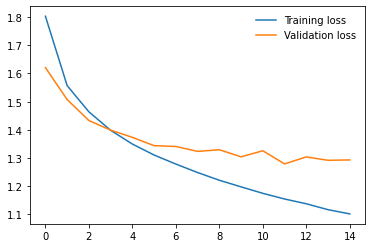

In [288]:
## YOUR CODE HERE ##
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [289]:
## YOUR CODE HERE ##
##I did it in the last code, it seems 55.3% accuracy

## Saving your model
Using `torch.save`, save your model for future loading.

In [290]:
## YOUR CODE HERE ##
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())
##Save Model
torch.save(model.state_dict(), 'checkpoint.pth')

Our model: 

 Sequential(
  (0): Linear(in_features=3072, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Double click this cell to modify it**



In [295]:

"""
Based on my evaluation, Currently. I would recommend buying.
 The accuracy of my model is lower compared to Detectocorp’s algorithm (55.3% VS 70%)
I have to say that 70% is not a good result, i would recommend looking for other companies andand check  if there are better algorithms in the market to predict the desired classes
to get my high accuracy, i try different optimizers, loss functions, number of hidden layers

I'm sure if i had more computation power I would get 70%+ accuracy  
"""


"\nBased on my evaluation, Currently. I would recommend buying.\n The accuracy of my model is lower compared to Detectocorp’s algorithm (55.3% VS 70%)\nI have to say that 70% is not a good result, i would recommend looking for other companies andand check  if there are better algorithms in the market to predict the desired classes\nto get my high accuracy, i try different optimizers, loss functions, number of hidden layers\n\nI'm sure if i had more computation power I would get 70%+ accuracy  \n"